# Fake News Detection using NLP Text Classification


### Fake news Detection using NLP text classification
The dataset used is the Kaggle dataset
https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset 
About the data:
- The basic objective task of the dataset has always been to create an algorithm that can determine if a given article is fake news or real. 
- The uploaded dataset is divided into two CSV files, ‘Fake.csv’ and ‘True.csv’. Combined there are a total of approximately 45,000 records. 
- There are only four columns in the dataset: title, text, subject and date. 
- The title of the news article is the headline itself while the text column contains the article text itself. 
- The subject column does not add much context to the dataset and the values are not consistent or balanced. 
- It most likely tries to describe the genre of the news each record belongs to. 
- The date of the record is simply the date when the article was published. The data is balanced since there are around 21,500 records in the ‘True’ file and approximately 23,500 records in the ‘False’ file. 

In [2]:
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [3]:

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [4]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.corpus import stopwords
import random
from sklearn.model_selection import train_test_split

In [5]:
true_news_data = pd.read_csv('True.csv')
true_news_data['IS_FAKE'] = 0 # Creating default column
true_news_data.head()

,title,text,subject,date,IS_FAKE
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [6]:
fake_news_data = pd.read_csv('Fake.csv')
fake_news_data['IS_FAKE'] = 1 # Creating default column
fake_news_data.head()

,title,text,subject,date,IS_FAKE
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [7]:
news_data = pd.concat([true_news_data,fake_news_data]).reset_index(drop = True)
news_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   IS_FAKE  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [8]:
news_data.describe()

,IS_FAKE
count,44898.000000
mean,0.522985
std,0.499477
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [9]:
news_data['subject'].unique()

array(['politicsNews', 'worldnews', 'News', 'politics', 'Government News',
       'left-news', 'US_News', 'Middle-east'], dtype=object)

In [10]:
news_data.IS_FAKE.value_counts()

1    23481
0    21417
Name: IS_FAKE, dtype: int64

In [11]:
news_data.isnull().count()

title      44898
text       44898
subject    44898
date       44898
IS_FAKE    44898
dtype: int64

In [12]:
news_data = news_data.fillna(0)

In [13]:
news_data.isnull().count()

title      44898
text       44898
subject    44898
date       44898
IS_FAKE    44898
dtype: int64

[Text(0, 0, '23481'), Text(0, 0, '21417')]

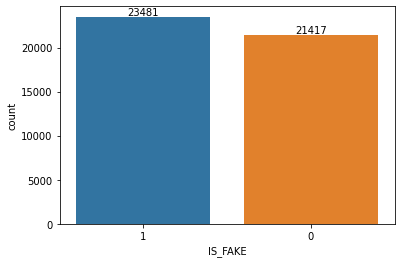

In [14]:
import seaborn as sns
ax = sns.countplot(x=news_data['IS_FAKE'],
                   order=news_data['IS_FAKE'].value_counts(ascending=False).index)
abs_values = news_data['IS_FAKE'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)


In [15]:
news_data["text"].map(str)

0        WASHINGTON (Reuters) - The head of a conservat...
1        WASHINGTON (Reuters) - Transgender people will...
2        WASHINGTON (Reuters) - The special counsel inv...
3        WASHINGTON (Reuters) - Trump campaign adviser ...
4        SEATTLE/WASHINGTON (Reuters) - President Donal...
                               ...                        
44893    21st Century Wire says As 21WIRE reported earl...
44894    21st Century Wire says It s a familiar theme. ...
44895    Patrick Henningsen  21st Century WireRemember ...
44896    21st Century Wire says Al Jazeera America will...
44897    21st Century Wire says As 21WIRE predicted in ...
Name: text, Length: 44898, dtype: object

In [18]:
y = news_data["IS_FAKE"]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: IS_FAKE, dtype: int64

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [21]:
X_train, X_test, y_train, y_test = train_test_split(news_data["text"], y, test_size=0.2)
print(len(X_train),len(X_test), len(y_train), len(y_test))


  


35918 8980 35918 8980


In [22]:
Tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train = Tfidf_vectorizer.fit_transform(X_train)
tfidf_test = Tfidf_vectorizer.transform(X_test)

In [23]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [24]:
pac=PassiveAggressiveClassifier(max_iter=50)
pac_res = pac.fit(tfidf_train,y_train)

In [25]:
y_pred_pac = pac_res.predict(tfidf_test)

In [26]:
print('Accuracy: ', accuracy_score(y_test, y_pred_pac))
print('Precision: ', precision_score(y_test, y_pred_pac))
print('Recall: ', recall_score(y_test, y_pred_pac))
print('f1-score: ', f1_score(y_test, y_pred_pac))

Accuracy:  0.994543429844098
Precision:  0.9949978251413658
Recall:  0.994349054553358
f1-score:  0.9946733340580498


In [27]:
from sklearn import metrics

In [28]:
print(metrics.classification_report(y_test, y_pred_pac))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4379
           1       0.99      0.99      0.99      4601

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [29]:
print(metrics.confusion_matrix(y_test, y_pred_pac))
plt.show()

[[4356   23]
 [  26 4575]]


In [30]:
from sklearn.metrics import plot_roc_curve

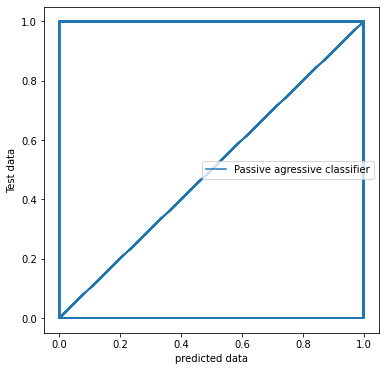

In [32]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(y_pred_pac, y_test, label='Passive agressive classifier')
#ax.plot(l2_fp_rates, l2_tp_rates, label='L2 Logistic Regression')
ax.set_xlabel('predicted data')
ax.set_ylabel('Test data')
ax.legend()

/Users/vrinda/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


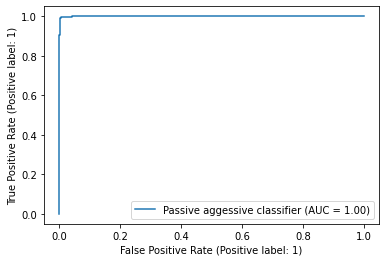

In [33]:
plot_roc_curve(pac, tfidf_test, y_test, name = 'Passive aggessive classifier')

/Users/vrinda/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


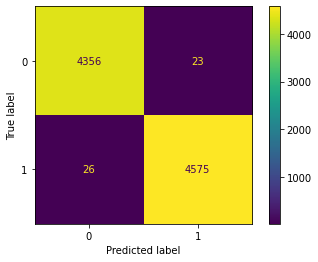

In [34]:
plot_confusion_matrix(pac, tfidf_test, y_test)  
plt.show()

In [35]:
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 99.45%


In [36]:
confusion_matrix(y_test,y_pred)

array([[4356,   23],
       [  26, 4575]])

/Users/vrinda/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


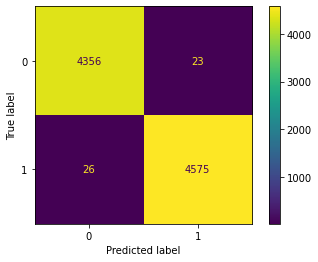

In [37]:
plot_confusion_matrix(pac, tfidf_test, y_test)  
plt.show()

#count Vectorizer & MutlinomialNB

(35918, 111586)
(35918, 111586)


/Users/vrinda/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


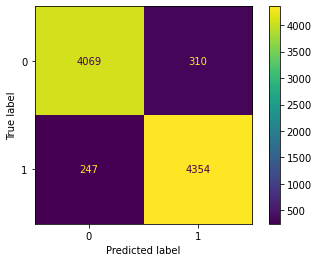

In [38]:
count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(X_train)
#    print(X_train_counts) 
#    print(count_vect.vocabulary_.get(u'algorithm'))
#    
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
print(X_train_tf.shape)


tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

plot_confusion_matrix(clf, tfidf_test, y_test)  
plt.show()


In [39]:
y_pred=clf.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 93.8%
